In [1]:
import pandas as pd
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv("Final/train.csv")
X = data.drop(columns=["result"]).values
y = data["result"].astype(int).values
split = int(len(X) * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [3]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(
        penalty="l2",
        C=1.0,
        solver="lbfgs",
        max_iter=2000,
        random_state=42))])

tscv = TimeSeriesSplit(n_splits=5)

fold_rows = []
oof_probs = np.full(shape=len(y), fill_value=np.nan, dtype=float) 

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    pipe.fit(X_train, y_train)
    p = pipe.predict_proba(X_test)[:, 1]
    oof_probs[test_idx] = p

    fold_rows.append({
        "fold": fold,
        "n_train": len(train_idx),
        "n_test": len(test_idx),
        "log_loss": log_loss(y_test, p),
        "brier": brier_score_loss(y_test, p),
        "auc": roc_auc_score(y_test, p),
        "acc": accuracy_score(y_test, (p >= 0.5).astype(int))})

results_df = pd.DataFrame(fold_rows)

print(results_df[["log_loss", "brier", "auc", "acc"]].mean())

log_loss    0.595255
brier       0.204903
auc         0.744329
acc         0.676259
dtype: float64


NaNs in oof_probs: 9688


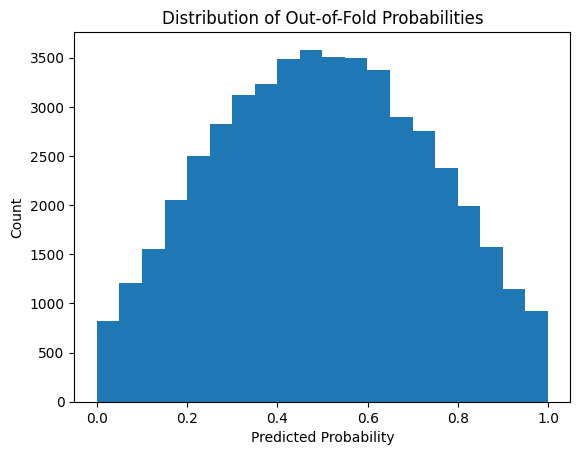

In [4]:
print("NaNs in oof_probs:", np.isnan(oof_probs).sum())

plt.hist(oof_probs[~np.isnan(oof_probs)], bins=20)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Distribution of Out-of-Fold Probabilities")
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Expected Calibration Error (ECE): Good way of measuring probability calibration (check readme for betetr description)
def expected_calibration_error(y_out, y_prob, n_bins=10, return_bins=False):
    y_out = np.asarray(y_out).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    m = ~np.isnan(y_prob)
    y_out = y_out[m]
    y_prob = y_prob[m]
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bin_edges, right=True) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)
    acc = np.full(n_bins, np.nan)
    conf = np.full(n_bins, np.nan)
    counts = np.zeros(n_bins, dtype=int)
    n = len(y_out)
    ece = 0.0

    for b in range(n_bins):
        idx = bin_ids == b
        counts[b] = idx.sum()
        if counts[b] > 0:
            acc[b] = y_out[idx].mean()
            conf[b] = y_prob[idx].mean()
            ece += (counts[b] / n) * abs(acc[b] - conf[b])
    if return_bins:
        return ece, acc, conf, counts, bin_edges
    return ece

#Plot reliability diagram and a probability histogram 
def reliability_diagram(y_out,y_prob,n_bins=10,hist_bins=30,title="Reliability Diagram"):
    
    ece, acc, conf, counts, bin_edges = expected_calibration_error(y_out, y_prob, n_bins=n_bins, return_bins=True)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (bin_edges[1] - bin_edges[0]) * 0.9
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 7),gridspec_kw={"height_ratios": [3, 2]})

    #reliability diagram
    ax1.plot([0, 1], [0, 1], linestyle="--", linewidth=2, label="Perfect calibration")
    ax1.bar(centers, np.nan_to_num(acc, nan=0.0), width=width, label="Accuracy")
    bottom = np.nan_to_num(np.minimum(acc, conf), nan=0.0)
    height = np.nan_to_num(np.abs(acc - conf), nan=0.0)
    ax1.bar(centers, height, bottom=bottom, width=width, hatch="xx", alpha=0.35,color="tab:red", label="Gap")
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.set_xlabel("Confidence")
    ax1.set_ylabel("Accuracy")
    ax1.set_title(title)

    # Display ECE in percentage points
    ax1.text(0.62, 0.06, f"ECE={ece*100:.2f}",
        transform=ax1.transAxes,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))
    ax1.legend(loc="upper left")

    #probability histogram 
    ax2.hist(y_prob, bins=hist_bins)
    ax2.set_xlim(0, 1)
    ax2.set_xlabel("Predicted probability")
    ax2.set_ylabel("Count")
    ax2.set_title("Predicted probability distribution")
    plt.tight_layout()
    plt.show()

    return ece


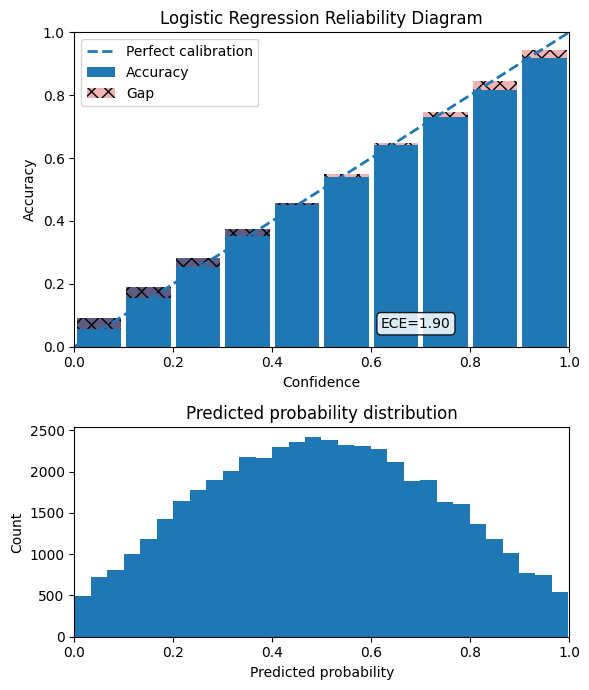

ECE: 0.019024372167121936


In [6]:
ece = reliability_diagram(y, oof_probs, n_bins=10, title="Logistic Regression Reliability Diagram")
print("ECE:", ece)
